In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

#### Examples: run one cell

In [2]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [3]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") :
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [3]:
# res, circ = swap_test(zero_state(2) |> push!(chain(2), put(1=>H)), zero_state(2))
state1 = rand_state(4)
state2 = rand_state(4)

res = swap_test(state1, state2)
res_des = destructive_swap_test(state1, state2)

println(abs2(dot(state1.state, state2.state)))
println(res)
println(res_des)

0.165586416616016
0.16799999999999998
0.132


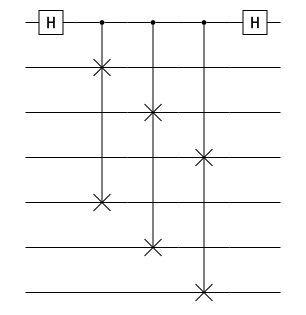

In [4]:
YaoPlots.plot(circ_swap_test(3))

In [9]:
function eval_grad2(state::Tuple{T, T} where T <: ArrayReg, p)
    state1, state2 = state
    n = nqubits(state1)
    circ = p.circ
    dispatch!(circ, expand_params(p))
    cost = destructive_swap_test(state1, state2)
    cost = circ_swap_test(n)
    _, grads = expect'(cost, (copy(state1), copy(state2)) => circ)
    return grads
end

eval_grad2((state1, state2), p)

MethodError: MethodError: no method matching (::Adjoint{Any, typeof(expect)})(::Float64, ::Pair{Tuple{ArrayReg{2, ComplexF64, Matrix{ComplexF64}}, ArrayReg{2, ComplexF64, Matrix{ComplexF64}}}, ChainBlock{2}})
Use square brackets [] for indexing an Array.
Closest candidates are:
  (::Adjoint{Any, typeof(expect)})(!Matched::AbstractBlock, ::Any) at ~/.julia/packages/YaoBlocks/BlXhZ/src/autodiff/specializes.jl:8

In [ ]:
chain()

In [10]:
test_state = rand_state(2)
print(test_state.state)
expect'(chain(2), test_state).state

ComplexF64[0.0016039834959582716 - 0.6231769374497185im; -0.19012491091402375 + 0.05900775575315134im; -0.03337007751113665 + 0.14235676858660526im; -0.6934163862769124 - 0.2642219492884602im;;]

4×1 Matrix{ComplexF64}:
 0.0032079669919165433 - 1.246353874899437im
   -0.3802498218280475 + 0.11801551150630268im
   -0.0667401550222733 + 0.2847135371732105im
   -1.3868327725538248 - 0.5284438985769204im

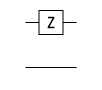

In [6]:
YaoPlots.plot(chain(2, put(1=>Z)))

#### Model parameters

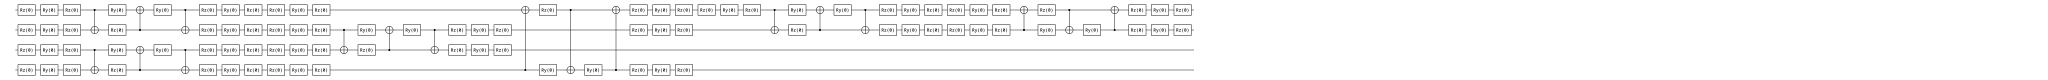

In [5]:
iters = 300 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function
ansatz = conv_SU4 # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

#### Run

In [6]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, optim, sig; output=false)

Initial: loss = 1.3226698213045038, tr_acc = 0.725, te_acc = 0.75
Final: loss = 0.0023789176744161587, tr_acc = 1.0, te_acc = 0.8


([2.557151447185976, 3.731940832790454, 4.449541967095675, 0.4035694482411156, 6.617615252227193, 2.161825779677297, 1.8240667636672627, -0.4673189959968425, 2.8927121260265123, 2.2477212857778084  …  4.310401862714719, 1.4336153546781425, 3.8000188943068722, 3.6166098489814136, 0.05461202475631643, 1.1091554765547749, 1.7311976756960248, 2.351699270077395, 2.5725225064151935, 5.549525057135336], [1.3226698213045038, 0.8900795964015865, 0.7948738075620208, 0.6386255314050934, 0.5780296503852713, 0.5634509110581036, 0.5962442648691323, 0.48143357668071163, 0.46278318359272846, 0.4520308342055037  …  0.0024240420117309933, 0.0024188492487808664, 0.0024137024587890968, 0.0024086011016734073, 0.0024035446443665728, 0.0023985325607013674, 0.0023935643312985744, 0.0023886394434577372, 0.002383757391050459, 0.0023789176744161587], [0.725, 0.675, 0.75, 0.825, 0.825, 0.825, 0.825, 0.85, 0.825, 0.825  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.75, 0.75, 0.775, 0.75, 0.75, 0.775, 0.

#### Plot

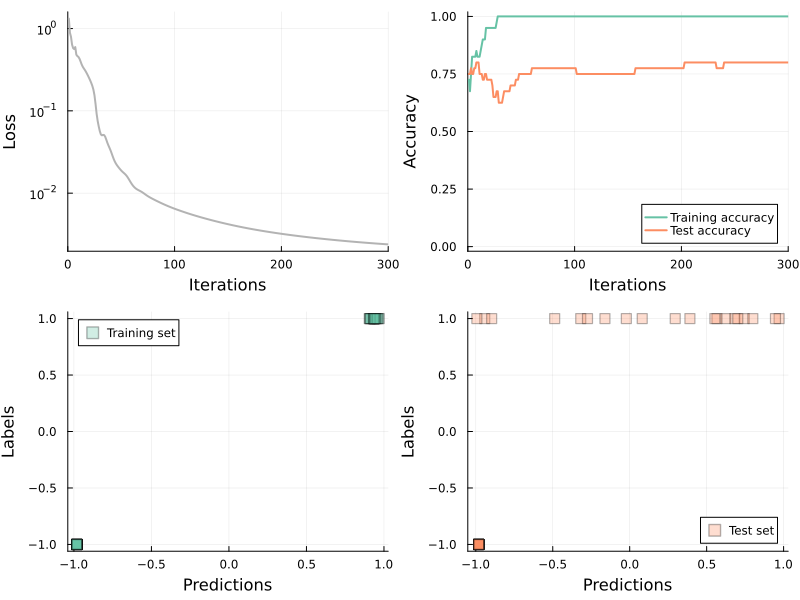

In [7]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))